<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/experimental/signal_kalman_banknifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b

     |████████████████████████████████| 228 kB 5.2 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=7968e4d8e08abbdba55851558b72d5cb19985bf9088ccd92ee3c0b5bd2d425d2
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman
     |████████████████████████████████| 6.3 MB 8.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 88 kB 3.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-py3-none-any.whl size=175303 sha256=f90d109d8158e6092eb896cb84996908ee2db78304322e69fbdb8587c904314e
  Stored in directory: /root/.cache/pip/wheels/b1/49/60/e674e28ae57160651c6198b76e1714a0b175e44e022fcd5137
Successfully built pandas-ta


In [2]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_niftyfmcglist.csv')

In [5]:
#ticker = pd.read_csv('https://raw.githubusercontent.com/anirbanghoshsbi/data/main/ind_nifty50list.csv')
START = "2013-01-01"

In [6]:
#nifty=yf.download('^nsebank',start=START)

In [ ]:
lst=[]
stockmst=[]
for i in range(len(ticker)):
  
  dfi = yf.download(str(ticker.Symbol.iloc[i])+'.ns', start=START)
  df = dfi[['Adj Close']]
  f = KalmanFilter(transition_matrices = [1],
                    observation_matrices = [1],
                    initial_state_mean = 0,
                    initial_state_covariance = 1,
                    observation_covariance = 1,
                    transition_covariance = 0.0001)
  mean, cov = f.filter(df['Adj Close'].values)
  mean, std = mean.squeeze(), np.std(cov.squeeze())
  var = 'kalman'
  df[var]=df['Adj Close'].values - mean
  stockmst.append(df['Adj Close'])
  lst.append(df)

In [9]:
weight_matrix=[0.2711, 0.2477, 0.860,0.643,0.575,0.480,0.453,0.390,0.374,0.273]
stocklst=[item*weight for item in stockmst for weight in  weight_matrix]

In [10]:
nifty=pd.DataFrame(stocklst).T.sum(axis=1)

In [11]:
nlst=[]
for i in range(len(ticker)):
  nlst.append(lst[i].kalman)
  

In [12]:
df_kalman = pd.DataFrame(nlst).T

In [13]:
namelist =[]
for i in range(1,len(ticker)+1):
  namelist.append('kalman_'+str(i))
  
df_kalman.columns = namelist

In [14]:
def macd_calc(df):
  columns=df.columns.tolist()
  for var in columns:
    macd='macd'+var
    macd_s='macd'+'signal'+var
    macd_h='hist'+ var
    df[macd]=df[var].ewm(span=26, adjust=False).mean()-df[var].ewm(span=50, adjust=False).mean()
    df[macd_s]=df[macd].ewm(span=18,adjust=False).mean()
    df[macd_h]=df[macd]-df[macd_s]
  return df

In [15]:
final_kalman=macd_calc(df_kalman)

In [16]:
final_kalman.tail(2)

,kalman_1,kalman_2,kalman_3,kalman_4,kalman_5,kalman_6,kalman_7,kalman_8,kalman_9,kalman_10,kalman_11,kalman_12,kalman_13,kalman_14,kalman_15,macdkalman_1,macdsignalkalman_1,histkalman_1,macdkalman_2,macdsignalkalman_2,histkalman_2,macdkalman_3,macdsignalkalman_3,histkalman_3,macdkalman_4,macdsignalkalman_4,histkalman_4,macdkalman_5,macdsignalkalman_5,histkalman_5,macdkalman_6,macdsignalkalman_6,histkalman_6,macdkalman_7,macdsignalkalman_7,histkalman_7,macdkalman_8,macdsignalkalman_8,histkalman_8,macdkalman_9,macdsignalkalman_9,histkalman_9,macdkalman_10,macdsignalkalman_10,histkalman_10,macdkalman_11,macdsignalkalman_11,histkalman_11,macdkalman_12,macdsignalkalman_12,histkalman_12,macdkalman_13,macdsignalkalman_13,histkalman_13,macdkalman_14,macdsignalkalman_14,histkalman_14,macdkalman_15,macdsignalkalman_15,histkalman_15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-17,-44.837299,-109.151624,34.878686,7.078007,14.338832,-38.495617,25.515370,51.988843,1327.049609,2051.158956,325.519905,101.809445,227.367973,215.579232,162.613992,-65.100472,-44.178736,-20.921736,-41.183839,-34.774376,-6.409464,-7.357212,-6.969714,-0.387498,-13.543861,-13.533060,-0.010801,-35.551702,-26.753173,-8.798529,-66.275060,-47.531015,-18.744046,0.457192,1.946123,-1.488931,-6.454989,-3.475938,-2.979051,-142.094806,-124.379241,-17.715565,166.749809,98.231203,68.518606,17.478154,21.693036,-4.214882,-11.054942,-11.532895,0.477953,12.482155,17.175764,-4.693609,28.914882,30.594398,-1.679516,0.348008,-1.570691,1.918699
2021-11-18,-87.408781,-115.243414,35.274176,-3.685007,12.117018,-29.944669,23.281389,41.620539,1243.006457,2094.509267,329.904397,96.489675,197.631749,205.216790,179.707930,-68.490306,-46.737848,-21.752457,-42.181698,-35.554094,-6.627604,-7.035163,-6.976604,-0.058560,-14.252471,-13.608787,-0.643684,-36.362802,-27.764713,-8.598090,-66.252607,-49.501709,-16.750898,0.471169,1.790865,-1.319695,-7.130035,-3.860580,-3.269455,-133.204536,-125.308220,-7.896316,179.445968,106.780125,72.665842,17.293987,21.229978,-3.935991,-11.118144,-11.489237,0.371093,9.002582,16.315429,-7.312848,26.951201,30.210903,-3.259702,0.937674,-1.306653,2.244327


In [17]:
features = final_kalman.columns.tolist()

In [18]:
feats_set1=[feats for feats in features if feats.startswith('hist')]

In [19]:
final_dataframe=final_kalman[feats_set1]

In [20]:
solution=np.sign(final_dataframe)

In [21]:
solution['final']=solution.sum(axis=1)

In [22]:
solution.tail(2)

,histkalman_1,histkalman_2,histkalman_3,histkalman_4,histkalman_5,histkalman_6,histkalman_7,histkalman_8,histkalman_9,histkalman_10,histkalman_11,histkalman_12,histkalman_13,histkalman_14,histkalman_15,final
Date,,,,,,,,,,,,,,,,
2021-11-17,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-9.0
2021-11-18,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-9.0


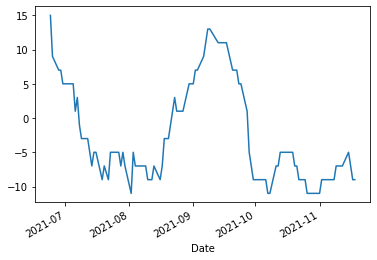

In [23]:
solution.final[-100:].plot()

In [24]:
l=700

In [25]:
nifty=nifty[-l:]
solution=solution[-l:]

In [26]:
nifty.tail(5)

Date
2021-11-12    228633.412022
2021-11-15    231450.217551
2021-11-16    230709.482048
2021-11-17    229839.284008
2021-11-18    229439.687335
dtype: float64

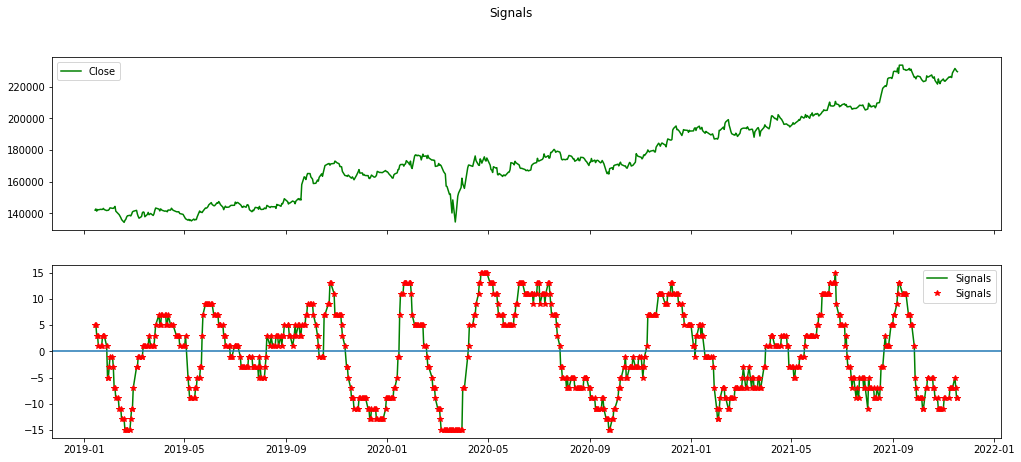

In [27]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty,'g', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'g', label='Signals')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'final'],'r*', label='Signals')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [28]:
solution['signals']=np.where(solution['final']>0,1,-1)

In [29]:
solution.final.tail(1)

Date
2021-11-18   -9.0
Name: final, dtype: float64

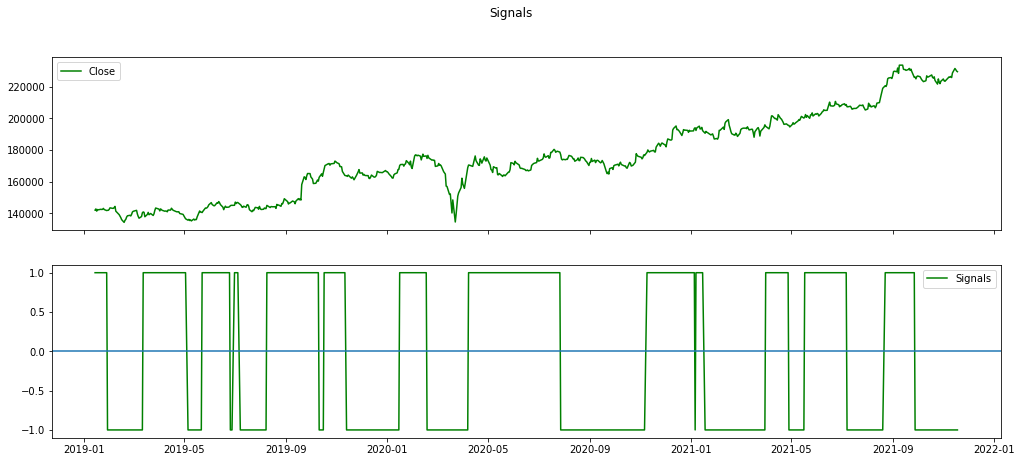

In [30]:
fig, ax = plt.subplots(2,1,figsize=(17,7),sharex=True)
ax[0].plot(nifty,'g', label='Close')
ax[1].plot(solution.loc[:, :].index, solution.loc[:, 'signals'],'g', label='Signals')
plt.suptitle('Signals')
ax[0].legend()
ax[1].legend()
ax[1].axhline(y=0)
plt.show()

In [31]:
solution[['signals']].to_csv('kalman_k.csv')

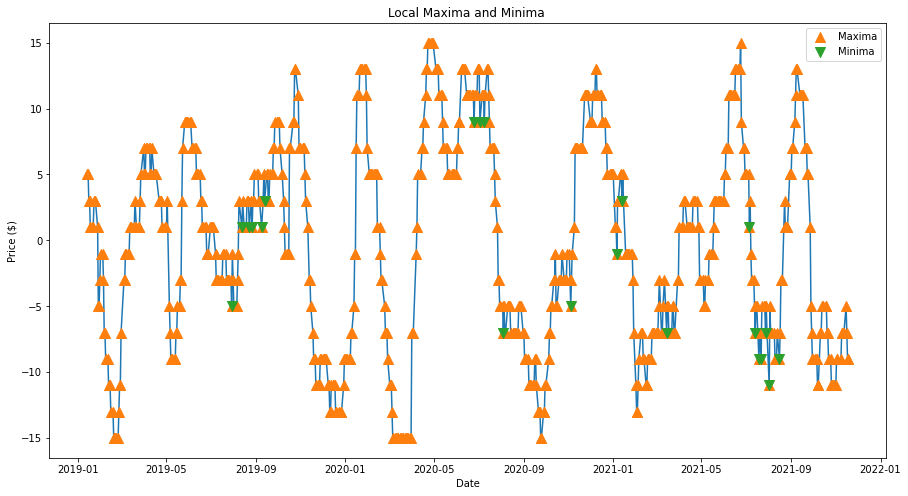

In [32]:
solution['local_max'] = solution['final'][
  (solution['final'].shift(1) < solution['final']) &
  (solution['final'].shift(-1) < solution['final'])]
solution['local_min'] = solution['final'][
  (solution['final'].shift(1) > solution['final']) &
  (solution['final'].shift(-1) > solution['final'])]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(15, 8))
plt.plot(solution['final'], zorder=0)
plt.scatter(solution.index, solution['final'], s=100,
  label='Maxima', marker='^', c=colors[1])
plt.scatter(solution.index, solution['local_min'], s=100,
  label='Minima', marker='v', c=colors[2])
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'Local Maxima and Minima ')
plt.legend()
plt.show()

In [33]:
from scipy.signal import argrelextrema

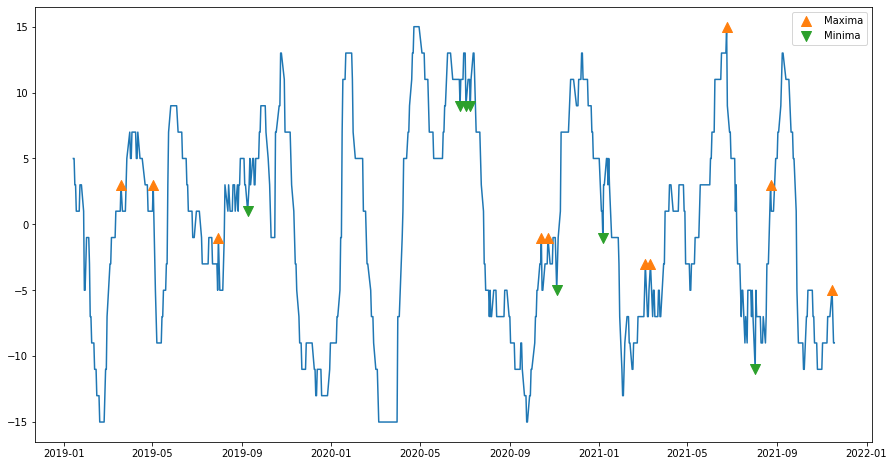

In [34]:
max_idx = argrelextrema(solution['final'].values, 
  np.greater, order=3)[0]
min_idx = argrelextrema(solution['final'].values, 
  np.less, order=3)[0]
plt.figure(figsize=(15, 8))
plt.plot(solution['final'], zorder=0)
plt.scatter(solution.iloc[max_idx].index, solution.iloc[max_idx]['final'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(solution.iloc[min_idx].index, solution.iloc[min_idx]['final'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.legend()
plt.show()